In [1]:
!apt install tesseract-ocr
!pip install pytesseract easyocr opencv-python -q
!pip install paddleocr paddlepaddle-gpu -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


https://www.kaggle.com/code/damthanh/text-detection-ocr

## 0. Import Libraries

In [2]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import re
plt.style.use('ggplot')
import easyocr
import pytesseract
import cv2
import paddle
from paddleocr import PaddleOCR,draw_ocr

In [3]:
kaggle_input_path = '/kaggle/input/'
data_input_path= 'textocr-text-extraction-from-images-dataset/'
annot = pd.read_parquet(kaggle_input_path+data_input_path+'annot.parquet')
imgs = pd.read_parquet(kaggle_input_path+data_input_path+'img.parquet')
img_fns = glob(kaggle_input_path+data_input_path+'train_val_images/train_images/*')

## 1. Observe

In [26]:
# test_img = img_fns[6]

In [39]:
test_img = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images/0007b54189a67423.jpg'

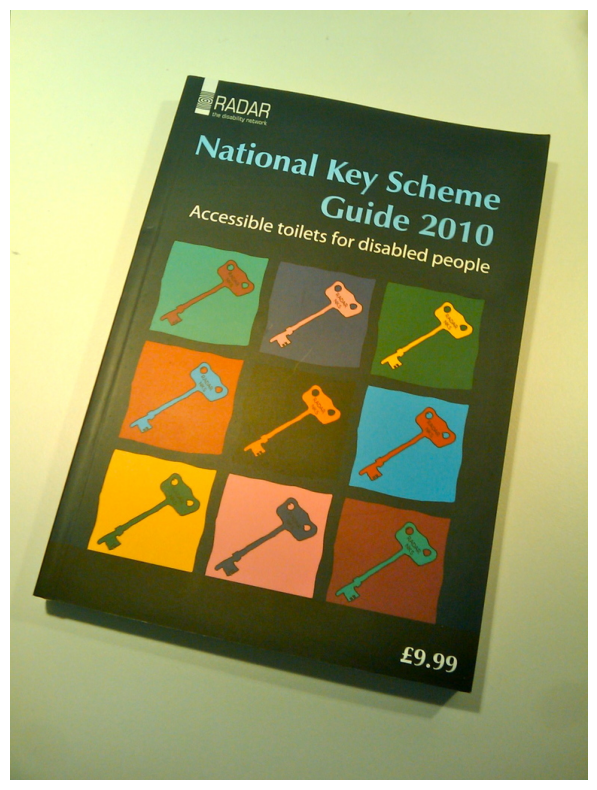

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(test_img))
ax.axis('off')
plt.show()

### 1.1 Static Funtion

In [15]:
def process_text(text):
    text = text.lower()
    processed_text = re.sub(r'[^a-z0-9\s]', '', text)  # Giữ chữ cái, số, và khoảng trắng
    processed_text = re.sub(r'\s+', ' ', processed_text)  # Loại bỏ khoảng trắng/tab dư thừa
    return processed_text.strip()
    
def get_raw_text_by_img_id(img):
    # Tách image_id từ đường dẫn hình ảnh
    image_id = img.split('/')[-1].split('.')[0]
    
    # Truy vấn DataFrame với image_id
    img_dataframe = annot.query('image_id == @image_id')
    
    # Lấy văn bản từ cột 'utf8_string'
    text = img_dataframe['utf8_string'].tolist()
    
    # Ghép các văn bản, chuyển chữ thường
    raw_text = ' '.join(text).lower()
    
    return process_text(raw_text)
    

In [41]:
get_raw_text_by_img_id(test_img)

'radar the disability network national key scheme guide 2010 people disabled for toilets accessible adar radar radar radar radar radar nk5 999'

## 2. EasyOCR method

In [18]:
reader = easyocr.Reader(['en'], gpu = True)

In [80]:
def easy_ocr(image_path):
    results = reader.readtext(image_path)
    d = pd.DataFrame(results, columns=['bbox','text','conf'])
    # Lấy văn bản từ cột 'utf8_string'
    text = d['text'].tolist()
    
    # Ghép các văn bản, chuyển chữ thường
    raw_text = ' '.join(text).lower()
    
    return process_text(raw_text)

In [81]:
easy_ocr(test_img)

'radar national key scheme guide accessible 2010 toilets for disabled people e999'

## 3. TesseractOCR method

In [102]:
def tesseract_ocr(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    text = pytesseract.image_to_string(image,lang='eng')
    return process_text(text)

In [103]:
tesseract_ocr(test_img)

'national key eee 2010 ue loy disableg people glee oon lo'

## 4. PaddleOCR method

In [ ]:
# ocr = PaddleOCR(use_angle_cls=True, lang='en')
# def paddle_ocr(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     result = ocr.ocr(image, cls=True)
#     for idx in range(len(result)):
#         res = result[idx]
#         print(res)
# paddle_ocr(test_img)